# IFT6135 - Homework 1 - CNN for MNIST dataset

Éric Girard, 
Camille Rochefort-Boulanger, 
Emad Takla

# READ ME

To run the code, the path for the data file (downloaded with the script given for the homework) need to be specified (see first cell in DATA section).

Also, the script creates a folder named "results" and inserts some pkl files in it when the models are trained.

# SET UP

In [0]:
import os
import pickle
import gzip
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

print(f"Pytorch version is {torch.__version__}.")

Pytorch version is 1.0.1.post2.


In [0]:
# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
    
print(device)

cuda


In [0]:
# spot to save your learning curves, and potentially checkpoint your models
savedir = 'results'
if not os.path.exists(savedir):
    os.makedirs(savedir)

# DATA

In [0]:
# MNIST data file
f = gzip.open('mnist.pkl.gz')
data_mnist = np.load(f, encoding='latin1')

In [0]:
# Data to tensors
train_images = torch.tensor([np.array([r.reshape(28,28)]) for r in data_mnist[0][0]], dtype=torch.float32)
train_labels = torch.tensor(data_mnist[0][1], dtype=torch.int64)

valid_images = torch.tensor([np.array([r.reshape(28,28)]) for r in data_mnist[1][0]], dtype=torch.float32)
valid_labels = torch.tensor(data_mnist[1][1], dtype=torch.int64)

test_images = torch.tensor([np.array([r.reshape(28,28)]) for r in data_mnist[1][0]], dtype=torch.float32)
test_labels = torch.tensor(data_mnist[1][1], dtype=torch.int64)

print("train images:", train_images.shape, "train labels:", train_labels.shape)
print("valid images:", valid_images.shape, "valid labels:", valid_labels.shape)
print("test images:", test_images.shape, "test labels:", test_labels.shape)

train images: torch.Size([50000, 1, 28, 28]) train labels: torch.Size([50000])
valid images: torch.Size([10000, 1, 28, 28]) valid labels: torch.Size([10000])
test images: torch.Size([10000, 1, 28, 28]) test labels: torch.Size([10000])


In [0]:
# Datasets
train_set = TensorDataset(train_images, train_labels)
valid_set = TensorDataset(valid_images, valid_labels)
test_set = TensorDataset(test_images, test_labels)

In [0]:
# DataLoaders
n_scratch = 64
batch_size=1000
batch_size_eval=512

# Subset to overfit
indices = list(range(len(train_set)))
scratch_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    # The sampler is an easy way to say that we're using the elements
    # `indices[:n_scratch]` for this loader
    sampler=SubsetRandomSampler(indices[:n_scratch]),
    num_workers=1,
    pin_memory=use_cuda
)

# Training set
train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=1,
    pin_memory=use_cuda
)

# Validation set
valid_loader = DataLoader(
    valid_set,
    batch_size=batch_size_eval,
    shuffle=True,
    #num_workers=1,
    pin_memory=use_cuda,
)

# Test set
test_loader = DataLoader(
    test_set,
    batch_size=batch_size_eval,
    #num_workers=1,
    pin_memory=use_cuda,
)

Shape of scratch torch.Size([64, 1, 28, 28]).


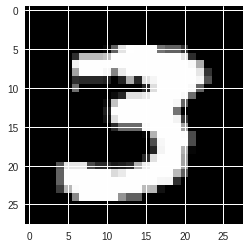

In [0]:
# Visualize the data
for inputs, targets in scratch_loader:
    print(f"Shape of scratch {inputs.shape}.")
    img = inputs[0,0]
    plt.imshow(img, cmap='Greys_r')
    break

# MODELS

The models CNN1, CNN2 and CNN3 are inspired from the HeavyNet model which was seen in IFT6390 class.

## CNN1

In [0]:
class CNN1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=0)
        self.fc = nn.Linear(128*5*5, 10)

    def forward(self, xin):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = xin + F.relu(self.conv1(xin))
        x = F.max_pool2d(x, 2) 
        # x is [b7s, 32, 14, 14]
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) 
        # x is [bs, 64, 7, 7]
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128*5*5 ) # flatten
        x = F.relu(self.fc(x))
        return x

## CNN2

In [0]:
class CNN2(nn.Module):
    
    def __init__(self):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        
        # conv block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        
        # fully connected layers
        self.fc1 = nn.Linear(64*7*7, 512)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2) # x is [bs, 32, 14, 14]
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2) # x is [bs, 64, 7, 7]
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## CNN3

In [0]:
class CNN3(nn.Module):
    
    def __init__(self):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # conv block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        
        # fully connected layers
        self.fc1 = nn.Linear(64*7*7, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2) # x is [bs, 32, 14, 14]
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2) # x is [bs, 64, 7, 7]
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

## Heavy Net

This is the code seen in the IFT6390 class.

In [0]:
class HeavyNet(nn.Module):
    """A medium sized network that performs very well on MNIST."""
    
    def __init__(self):
        super().__init__()
        # conv block 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        # conv block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        # fully connected layers
        self.fc1 = nn.Linear(64*7*7, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 10)
        
    def forward(self, x):
        # x is [batch_size, channels, heigth, width] = [bs, 1, 28, 28]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2) # x is [bs, 32, 14, 14]
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2) # x is [bs, 64, 7, 7]
        
        x = x.view(x.size(0), -1) # flatten
        
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# TRAIN & TEST FUNCTIONS

In [0]:
# Surrogate loss used for training
loss_fn = nn.CrossEntropyLoss()
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')

In [0]:
def train(model,train_loader, optimizer, epoch ):
    """Perform one epoch of training."""
    model.train()
    correct = 0
    train_size = 0
    for batch_idx, (inputs, target) in enumerate(train_loader):
        inputs, target = inputs.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(inputs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_size += len(inputs)
        train_loss = loss_fn(output, target)
        train_loss.backward()
        optimizer.step()
        
    train_loss /= train_size
    accuracy = float(correct) / train_size
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      train_loss, correct, train_size, 100. * accuracy))
    
    return accuracy

In [0]:
def test(model, test_loader):
    """Evaluate the model by doing one pass over a dataset"""
    model.eval()
    
    test_loss = 0
    correct = 0
    test_size = 0
    with torch.no_grad():
        for inputs, target in test_loader:
            inputs, target = inputs.to(device), target.to(device)
            
            # let them code what's here
            output = model(inputs)
            test_size += len(inputs)
            test_loss += test_loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= test_size
    accuracy = correct / test_size
    """
    print('\nTest (or valid) set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size,
        100. * accuracy))
    """
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, test_size, 100. * accuracy))
    
    return test_loss, accuracy

# TRAINING

## Overfitting with scratch dataset

### CNN1

In [0]:
# Overfitting
model = CNN1().to(device)
model_evol = []
lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[], 't_accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(0, 50):
    print ('epoch {}'.format(epoch))
    train_acc = train(model, train_loader, optimizer, epoch)

epoch 0
Train set: Average loss: 0.0000, Accuracy: 28640/50000 (57%)

epoch 1
Train set: Average loss: 0.0000, Accuracy: 33996/50000 (68%)

epoch 2
Train set: Average loss: 0.0000, Accuracy: 34378/50000 (69%)

epoch 3
Train set: Average loss: 0.0000, Accuracy: 34493/50000 (69%)

epoch 4
Train set: Average loss: 0.0000, Accuracy: 34594/50000 (69%)

epoch 5
Train set: Average loss: 0.0000, Accuracy: 34620/50000 (69%)

epoch 6
Train set: Average loss: 0.0000, Accuracy: 34690/50000 (69%)

epoch 7
Train set: Average loss: 0.0000, Accuracy: 34680/50000 (69%)

epoch 8
Train set: Average loss: 0.0000, Accuracy: 34753/50000 (70%)

epoch 9
Train set: Average loss: 0.0000, Accuracy: 34757/50000 (70%)

epoch 10
Train set: Average loss: 0.0000, Accuracy: 34767/50000 (70%)

epoch 11
Train set: Average loss: 0.0000, Accuracy: 34805/50000 (70%)

epoch 12
Train set: Average loss: 0.0000, Accuracy: 34815/50000 (70%)

epoch 13
Train set: Average loss: 0.0000, Accuracy: 34827/50000 (70%)

epoch 14
Train s

### CNN2

In [0]:
# Overfitting
model = CNN2().to(device)
model_evol = []
lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[], 't_accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(0, 50):
    print ('epoch {}'.format(epoch))
    train_acc = train(model, train_loader, optimizer, epoch)

epoch 0
Train set: Average loss: 0.0000, Accuracy: 31746/50000 (63%)

epoch 1
Train set: Average loss: 0.0000, Accuracy: 47326/50000 (95%)

epoch 2
Train set: Average loss: 0.0000, Accuracy: 48516/50000 (97%)

epoch 3
Train set: Average loss: 0.0000, Accuracy: 48898/50000 (98%)

epoch 4
Train set: Average loss: 0.0000, Accuracy: 49077/50000 (98%)

epoch 5
Train set: Average loss: 0.0000, Accuracy: 49274/50000 (99%)

epoch 6
Train set: Average loss: 0.0000, Accuracy: 49344/50000 (99%)

epoch 7
Train set: Average loss: 0.0000, Accuracy: 49409/50000 (99%)

epoch 8
Train set: Average loss: 0.0000, Accuracy: 49507/50000 (99%)

epoch 9
Train set: Average loss: 0.0000, Accuracy: 49527/50000 (99%)

epoch 10
Train set: Average loss: 0.0000, Accuracy: 49609/50000 (99%)

epoch 11
Train set: Average loss: 0.0000, Accuracy: 49656/50000 (99%)

epoch 12
Train set: Average loss: 0.0000, Accuracy: 49701/50000 (99%)

epoch 13
Train set: Average loss: 0.0000, Accuracy: 49693/50000 (99%)

epoch 14
Train s

### CNN3

In [0]:
# Overfitting
model = CNN3().to(device)
model_evol = []
lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[], 't_accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(0, 50):
    print ('epoch {}'.format(epoch))
    train_acc = train(model, train_loader, optimizer, epoch)

epoch 0
Train set: Average loss: 0.0000, Accuracy: 45714/50000 (91%)

epoch 1
Train set: Average loss: 0.0000, Accuracy: 49111/50000 (98%)

epoch 2
Train set: Average loss: 0.0000, Accuracy: 49413/50000 (99%)

epoch 3
Train set: Average loss: 0.0000, Accuracy: 49547/50000 (99%)

epoch 4
Train set: Average loss: 0.0000, Accuracy: 49658/50000 (99%)

epoch 5
Train set: Average loss: 0.0000, Accuracy: 49721/50000 (99%)

epoch 6
Train set: Average loss: 0.0000, Accuracy: 49798/50000 (100%)

epoch 7
Train set: Average loss: 0.0000, Accuracy: 49843/50000 (100%)

epoch 8
Train set: Average loss: 0.0000, Accuracy: 49883/50000 (100%)

epoch 9
Train set: Average loss: 0.0000, Accuracy: 49907/50000 (100%)

epoch 10
Train set: Average loss: 0.0000, Accuracy: 49932/50000 (100%)

epoch 11
Train set: Average loss: 0.0000, Accuracy: 49955/50000 (100%)

epoch 12
Train set: Average loss: 0.0000, Accuracy: 49974/50000 (100%)

epoch 13
Train set: Average loss: 0.0000, Accuracy: 49982/50000 (100%)

epoch 14

### Heavy Net

In [0]:
# Overfitting
model = HeavyNet().to(device)
model_evol = []
lr = 0.05
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'basic', 'lr': lr, 'loss': [], 'accuracy':[], 't_accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(0, 50):
    print ('epoch {}'.format(epoch))
    train_acc = train(model, train_loader, optimizer, epoch)

epoch 0
Train set: Average loss: 0.0000, Accuracy: 46131/50000 (92%)

epoch 1
Train set: Average loss: 0.0000, Accuracy: 49313/50000 (99%)

epoch 2
Train set: Average loss: 0.0000, Accuracy: 49531/50000 (99%)

epoch 3
Train set: Average loss: 0.0000, Accuracy: 49689/50000 (99%)

epoch 4
Train set: Average loss: 0.0000, Accuracy: 49761/50000 (100%)

epoch 5
Train set: Average loss: 0.0000, Accuracy: 49823/50000 (100%)

epoch 6
Train set: Average loss: 0.0000, Accuracy: 49893/50000 (100%)

epoch 7
Train set: Average loss: 0.0000, Accuracy: 49900/50000 (100%)

epoch 8
Train set: Average loss: 0.0000, Accuracy: 49930/50000 (100%)

epoch 9
Train set: Average loss: 0.0000, Accuracy: 49964/50000 (100%)

epoch 10
Train set: Average loss: 0.0000, Accuracy: 49978/50000 (100%)

epoch 11
Train set: Average loss: 0.0000, Accuracy: 49980/50000 (100%)

epoch 12
Train set: Average loss: 0.0000, Accuracy: 49990/50000 (100%)

epoch 13
Train set: Average loss: 0.0000, Accuracy: 49992/50000 (100%)

epoch 

## Train dataset

In [0]:
model = CNN2().to(device)
model_evol = []
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'cnn2', 'lr': lr, 'loss': [], 'accuracy':[], 't_accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(0, 100):
    print ('epoch {}'.format(epoch))
    train_acc = train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader)
    model_evol.append(model)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    results['t_accuracy'].append(train_acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

epoch 0
Train set: Average loss: 0.0000, Accuracy: 17103/50000 (34%)

Test set: Average loss: 2.1215, Accuracy: 6240/10000 (62%)

epoch 1
Train set: Average loss: 0.0000, Accuracy: 34670/50000 (69%)

Test set: Average loss: 0.6332, Accuracy: 8174/10000 (82%)

epoch 2
Train set: Average loss: 0.0000, Accuracy: 42548/50000 (85%)

Test set: Average loss: 0.3611, Accuracy: 8908/10000 (89%)

epoch 3
Train set: Average loss: 0.0000, Accuracy: 44501/50000 (89%)

Test set: Average loss: 0.2994, Accuracy: 9111/10000 (91%)

epoch 4
Train set: Average loss: 0.0000, Accuracy: 45234/50000 (90%)

Test set: Average loss: 0.2665, Accuracy: 9214/10000 (92%)

epoch 5
Train set: Average loss: 0.0000, Accuracy: 45744/50000 (91%)

Test set: Average loss: 0.2372, Accuracy: 9297/10000 (93%)

epoch 6
Train set: Average loss: 0.0000, Accuracy: 46236/50000 (92%)

Test set: Average loss: 0.2156, Accuracy: 9367/10000 (94%)

epoch 7
Train set: Average loss: 0.0000, Accuracy: 46556/50000 (93%)

Test set: Average lo

In [0]:
model = CNN3().to(device)
model_evol = []
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

results = {'name':'cnn3', 'lr': lr, 'loss': [], 'accuracy':[], 't_accuracy':[]}
savefile = os.path.join(savedir, results['name']+str(results['lr'])+'.pkl' )

for epoch in range(0, 100):
    print ('epoch {}'.format(epoch))
    train_acc = train(model, train_loader, optimizer, epoch)
    loss, acc = test(model, valid_loader)
    model_evol.append(model)
    
    # save results every epoch
    results['loss'].append(loss)
    results['accuracy'].append(acc)
    results['t_accuracy'].append(train_acc)
    with open(savefile, 'wb') as fout:
        pickle.dump(results, fout)

epoch 0
Train set: Average loss: 0.0000, Accuracy: 39832/50000 (80%)

Test set: Average loss: 0.4174, Accuracy: 9273/10000 (93%)

epoch 1
Train set: Average loss: 0.0000, Accuracy: 47527/50000 (95%)

Test set: Average loss: 0.1619, Accuracy: 9693/10000 (97%)

epoch 2
Train set: Average loss: 0.0000, Accuracy: 48363/50000 (97%)

Test set: Average loss: 0.1169, Accuracy: 9765/10000 (98%)

epoch 3
Train set: Average loss: 0.0000, Accuracy: 48739/50000 (97%)

Test set: Average loss: 0.0953, Accuracy: 9801/10000 (98%)

epoch 4
Train set: Average loss: 0.0000, Accuracy: 48933/50000 (98%)

Test set: Average loss: 0.0836, Accuracy: 9812/10000 (98%)

epoch 5
Train set: Average loss: 0.0000, Accuracy: 49090/50000 (98%)

Test set: Average loss: 0.0741, Accuracy: 9828/10000 (98%)

epoch 6
Train set: Average loss: 0.0000, Accuracy: 49190/50000 (98%)

Test set: Average loss: 0.0678, Accuracy: 9839/10000 (98%)

epoch 7
Train set: Average loss: 0.0000, Accuracy: 49261/50000 (99%)

Test set: Average lo

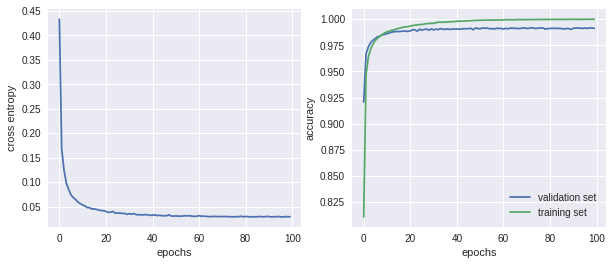

In [0]:
# PLOTTING
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for filename in os.listdir(savedir):
    if filename.endswith('.pkl'):
        with open(os.path.join(savedir, filename),'rb') as fin:
            results = pickle.load(fin)
            ax1.plot(results['loss'])
            ax1.set_ylabel('cross entropy')
            ax1.set_xlabel('epochs')
            
            ax2.plot(results['accuracy'], label = "validation set")
            ax2.plot(results['t_accuracy'], label = "training set")
            ax2.set_ylabel('accuracy')
            ax2.set_xlabel('epochs')
            
plt.legend()
plt.savefig("cnn3.png")

# TEST

In [0]:
# Chosen model
chosen_model = model_evol[5]
test(model, test_loader)

Test set: Average loss: 0.0305, Accuracy: 9910/10000 (99%)



(0.030497188472747804, 0.991)